# SR Volume by Ministry (YTD)

This notebook processes the SRM raw data as required and produces the graph for the SR volume by Ministry, as used in the SRM datapack.

## Steps

1. Upload current status standing data and raw data
2. Keep necessary columns, remove the unnecessary ones from raw data
3. Create "Most Recent Action Column" and append to raw data
4. Merge raw-data with standing data
5. Add status column
6. Make graph


In [41]:
# IMPORTS AND STANDING DATA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#status standing data
current_status = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-current-status.csv')
# Which AUs belong to which ministry standing data
au_ministry_data = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-au-ministry.csv')
#current_status.iloc[64,0]
# Analysis date
analysis_date = datetime(2023, 3, 1)

In [42]:
# Import Raw Data and drop unneeded columns
df = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/raw-data/srm-raw-data/230301-srm-raw-data.csv', low_memory=False)

In [43]:
# Define function to remove extra characters from string
def remove_extra_chars(string):
    return string.split(' $')[0]

# Apply function to 'Current State' column
df['Current State'] = df['Current State'].apply(remove_extra_chars)

# Display updated dataframe
#df['Current State'].unique()

In [44]:
#df
# Columns to keep immediately
df_columns_to_keep = [
        'Srid','Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Entity','Account Code','Exchange Rate','Total Cost Of Line','Amended Total Cost Of Line',
        'Savings Of Line','Total Sr Savings','Spending Team Action','Spending Team Action Date',
        'Price Evaluation Action','Price Evaluation Action Date','Engineering Directorate Action',
        'Engineering Directorate Action Date','Publications Directorate Action','Publications Directorate Action Date',
        'Director Of Spending Action','Director Of Spending Action Date','Dg Pa Action','Dg Pa Action Date',
        'Minister Of Finance Action','Minister Of Finance Action Date','Com Action','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date','Second Round Com Action Date',
        'Second Round Final Approval Date','Final Approval Date','Current State']
df_filtered = df.loc[:, df_columns_to_keep]
#df_filtered.head(5)

In [45]:
# Create a Most Recent Action column
columns_to_include = [
        'Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Spending Team Action Date',
        'Price Evaluation Action Date',
        'Engineering Directorate Action Date','Publications Directorate Action Date',
        'Director Of Spending Action Date','Dg Pa Action Date',
        'Minister Of Finance Action Date','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date',
        'Second Round Com Action Date','Second Round Final Approval Date','Final Approval Date']

df_filtered['Most Recent Action'] = df_filtered[columns_to_include].max(axis=1)

# convert date_column to datetime format
df_filtered['Most Recent Action'] = pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d %I:%M %p', errors='coerce').fillna(pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d', errors='coerce'))

#df_filtered['Most Recent Action'].isna().sum()

In [48]:
# Merge standing data and raw data to get the status'
current_status['Current State'] = current_status['Current State'].str.upper()
df_filtered['Current State'] = df_filtered['Current State'].str.upper()
df_filtered = pd.merge(df_filtered, current_status,how='left', on='Current State')


In [49]:
# ADD STATUS COLUMN
def final_status(row):
    if row['Current State'] == "REVOKED" and row['Date Submitted To Mofe'] == "-":
        return "Not Submitted"
    
    elif row['Current State'] == "REVOKED" and row['Final Approval Date'] != "-":
        if row[26] == "Approved By Minister Of Finance" or row[26] == "Amended and Approved By Minister Of Finance" or  row[26] == "Pending Tender":
            return "Revoked After Approval"
        
        elif row[28] == "Approved By Council Of Ministers" or row[28] == "Amended And Approved By Council Of Ministers" or row[28] == "Pending Tender By Council Of Ministers":
            return "Revoked After Approval"
        
        elif row[26] == "Rejected By Minister Of Finance" or row[28] == "Rejected By Council Of Ministers":
            return "Revoked After Rejection"
        
    elif row[42] == 'In process':
        return 'In Process'
    
    elif row[42] == 'Not submitted':
        return 'Not Submitted'
    
    elif row[42] == 'Revoked':
        return 'Revoked'
    
    elif row[42] == 'Rejected':
        return 'Rejected'
    
    elif row[42] == 'Approved':
        if row[13] == 0:
            return 'Approved'
        else:
            return 'Amended'
    else:
        return np.nan
    
df_filtered['Final Status'] = df_filtered.apply(final_status, axis=1)

In [50]:
# Add ministry column
df_filtered_ministry = pd.merge(df_filtered, au_ministry_data,how='left', on='Entity')
#df_filtered_ministry.head(5)
#df_filtered_ministry['Ministry'].isna().sum()

# Create Table for Graph


In [51]:
# Filter the original dataframe for Most Recent Action date within the last 90 days
recent_actions = df_filtered_ministry[df_filtered_ministry['Most Recent Action'] >= analysis_date - timedelta(days=90)]

# Create a new dataframe for status by ministry
status_by_ministry = pd.DataFrame(columns=['Ministry', 'Approved', 'Amended', 'Rejected'])

# Populate the 'ministry' column with unique ministry names from the original dataframe
status_by_ministry['Ministry'] = df_filtered_ministry['Ministry'].unique()

# group by 'Ministry' and 'Final Status', and count unique 'Srid' values
status_by_ministry = df_filtered_ministry.groupby(['Ministry', 'Final Status'])['Srid'].nunique().reset_index()

# pivot table to get the desired structure
status_by_ministry = status_by_ministry.pivot(index='Ministry', columns='Final Status', values='Srid').reset_index()

# add missing columns with 0 count
if 'Approved' not in status_by_ministry.columns:
    status_by_ministry['Approved'] = 0
if 'Amended' not in status_by_ministry.columns:
    status_by_ministry['Amended'] = 0
if 'Rejected' not in status_by_ministry.columns:
    status_by_ministry['Rejected'] = 0
    
status_by_ministry['Processed'] = status_by_ministry.apply(lambda row: row.Approved + row.Amended + row.Rejected, axis=1)
    
# reorder columns
status_by_ministry = status_by_ministry[['Ministry', 'Approved', 'Amended', 'Rejected', 'Processed']]

status_by_ministry = status_by_ministry.fillna(0)

In [52]:
status_by_ministry

Final Status,Ministry,Approved,Amended,Rejected,Processed
0,BOE,16.0,6.0,1.0,23.0
1,BOI,30.0,7.0,6.0,43.0
2,COM,214.0,25.0,0.0,0.0
3,HRB,7.0,0.0,0.0,0.0
4,KAGB,24.0,5.0,4.0,33.0
5,KSAB,1.0,2.0,0.0,0.0
6,MAA,31.0,2.0,4.0,37.0
7,MNR,33.0,6.0,5.0,44.0
8,MOAWR,284.0,130.0,26.0,440.0
9,MOCY,184.0,283.0,227.0,694.0


In [53]:
status_by_ministry = status_by_ministry.sort_values(by=['Processed'],ascending=False)
status_by_ministry = status_by_ministry.set_index('Ministry')
#status_by_ministry = status_by_ministry.reset_index(drop=True)
#status_by_ministry.set_index('Ministry')
status_by_ministry

Final Status,Approved,Amended,Rejected,Processed
Ministry,,,,
MOFE,1773.0,400.0,62.0,2235.0
MOH,965.0,278.0,180.0,1423.0
MOHE,666.0,406.0,297.0,1369.0
MOMT,978.0,284.0,79.0,1341.0
MOE,918.0,202.0,91.0,1211.0
MOCY,184.0,283.0,227.0,694.0
MOI,412.0,206.0,33.0,651.0
MOHR,225.0,197.0,187.0,609.0
MOTI,476.0,105.0,12.0,593.0


# Code to make graph


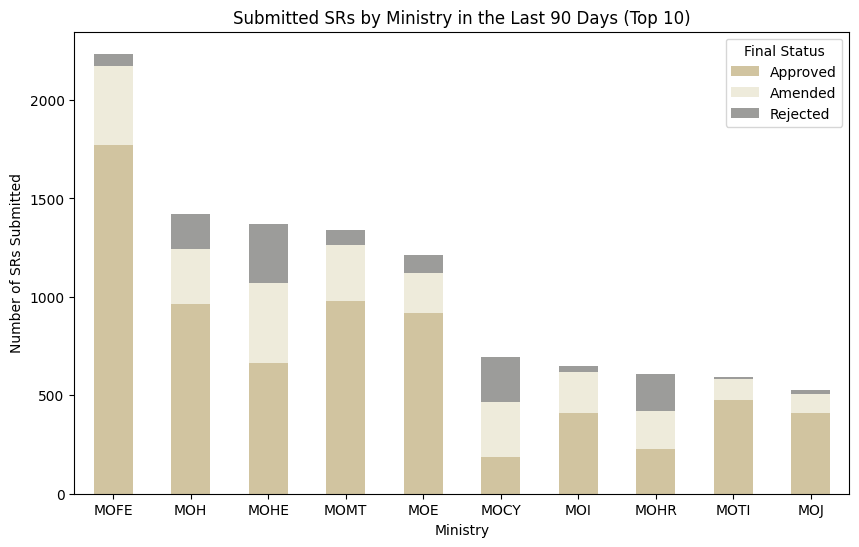

In [58]:
# Set the 'ministry' column as the index


colors = ['#a58b4280','#dfd8b880','#3b3a3780']

# Create a stacked bar chart
status_by_ministry.iloc[:10,:-1].plot(kind='bar', stacked=True, figsize=(10, 6),color=colors)

# Set the title and axis labels
plt.title('Submitted SRs by Ministry in the Last 90 Days (Top 10)')
plt.xlabel('Ministry')
plt.ylabel('Number of SRs Submitted')
plt.xticks(rotation=0)

# Show the plot
plt.show()